In [1]:
import json

import numpy as np
import matplotlib.pyplot as plt

import cv2

In [2]:
def _load_json(p):
    with open(p, 'r', encoding='utf-8') as f:
        return json.load(f)

In [3]:
data_edge = _load_json('images/board_canonical_edge.json')
data_grid = _load_json('images/board_canonical_grid.json')

In [4]:
im_raw = cv2.imread('images/board_canonical.png')
im_raw = cv2.cvtColor(im_raw, cv2.COLOR_BGR2RGB)

In [5]:
def _region_to_coords(d):
    return np.array([[p['x'], p['y']] for p in d], dtype=np.int32)

In [6]:
corners_edge = _region_to_coords(data_edge)
corners_grid = _region_to_coords(data_grid)

In [7]:
im = im_raw.copy()
im = cv2.polylines(im, [corners_edge], isClosed=True, color=(255, 0, 0), thickness=10)
im = cv2.polylines(im, [corners_grid], isClosed=True, color=(0, 0, 255), thickness=10)

(-0.5, 3023.5, 4031.5, -0.5)

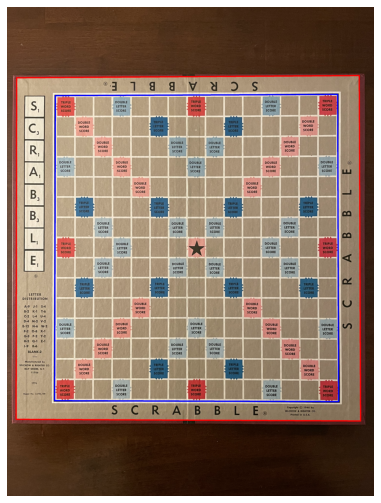

In [8]:
fig = plt.figure(figsize=(9, 9))
plt.imshow(im)
plt.axis('off')

In [9]:
canonical_len_px = 15 * 125
canonical_corners_edge = np.array([[0,                0],
                                   [canonical_len_px, 0],
                                   [canonical_len_px, canonical_len_px],
                                   [0,                canonical_len_px]], dtype=np.int32)

(-0.5, 1874.5, 1874.5, -0.5)

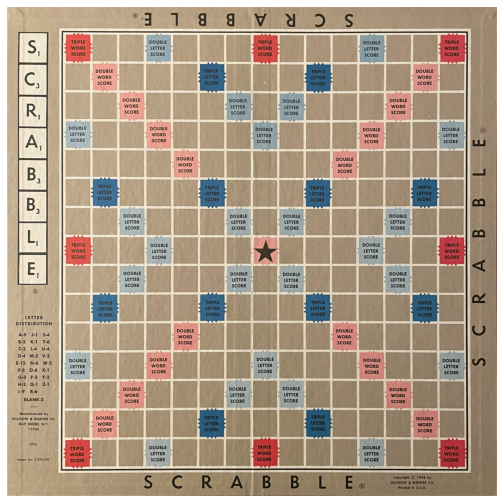

In [10]:
H, _ = cv2.findHomography(corners_edge, canonical_corners_edge)
im_canonical = cv2.warpPerspective(im_raw, H, dsize=(canonical_len_px, canonical_len_px))

fig = plt.figure(figsize=(9, 9))
plt.imshow(im_canonical)
plt.axis('off')

In [11]:
def _apply_homography(Hmat, p_im):
    res = (Hmat @ np.hstack([p_im, np.ones(p_im.shape[0])[:, None]]).T).T
    return res[:, :2] / res[:, 2:]

In [12]:
p_Cgrid_Cobs = _apply_homography(H, corners_grid)
print(p_Cgrid_Cobs)

[[ 214.02335869   99.78186385]
 [1757.62326223  102.09124119]
 [1757.00910607 1771.09569219]
 [ 211.40377438 1771.95168362]]


In [13]:
xmin = 0.5 * (p_Cgrid_Cobs[0, 0] + p_Cgrid_Cobs[3, 0])
xmax = 0.5 * (p_Cgrid_Cobs[1, 0] + p_Cgrid_Cobs[2, 0])
ymin = 0.5 * (p_Cgrid_Cobs[0, 1] + p_Cgrid_Cobs[1, 1])
ymax = 0.5 * (p_Cgrid_Cobs[2, 1] + p_Cgrid_Cobs[3, 1])
p_Cgrid_C = np.array([[xmin, ymin],
                      [xmax, ymin],
                      [xmax, ymax],
                      [xmin, ymax]], dtype=np.int32)

tile_xlen_px = int((xmax - xmin) / 15)
tile_ylen_px = int((ymax - ymin) / 15)

(-0.5, 1874.5, 1874.5, -0.5)

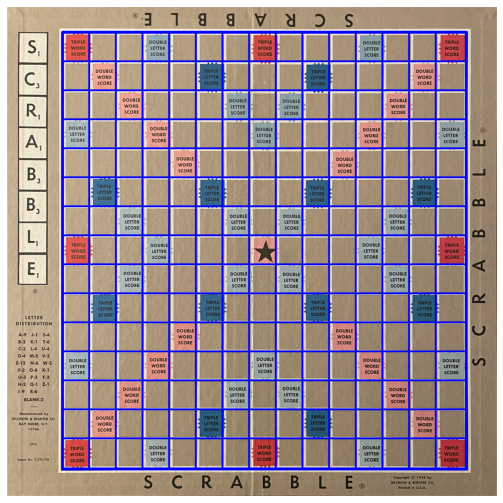

In [14]:
im = im_canonical.copy()
im = cv2.polylines(im, [p_Cgrid_C], isClosed=True, color=(0, 0, 255), thickness=10)

for i in range(14):
    dx = int(xmin + (i + 1) * tile_xlen_px)
    im = cv2.line(im, (dx, int(ymin)), (dx, int(ymax)), (0, 0, 255), 5)
    
    dy = int(ymin + (i + 1) * tile_ylen_px)
    im = cv2.line(im, (int(xmin), dy), (int(xmax), dy), (0, 0, 255), 5)

fig = plt.figure(figsize=(9, 9))
plt.imshow(im)
plt.axis('off')

In [15]:
sift = cv2.SIFT_create()

In [16]:
kp_canonical, des_canonical = sift.detectAndCompute(im_canonical, None)

(-0.5, 4031.5, 3023.5, -0.5)

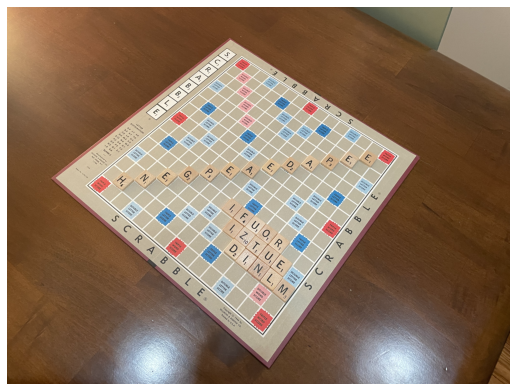

In [17]:
im_test = cv2.imread('images/board_letters2.png')
im_test = cv2.cvtColor(im_test, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(9, 9))
plt.imshow(im_test)
plt.axis('off')

In [18]:
kp_test, des_test = sift.detectAndCompute(im_test, None)

In [19]:
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des_canonical, des_test, k=2)

In [20]:
good = []
for (m,n) in matches:
    if m.distance < 0.7 * n.distance:
        good.append(m)

In [21]:
pts_canonical = np.float32([kp_canonical[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
pts_test = np.float32([kp_test[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

M, mask = cv2.findHomography(pts_test, pts_canonical, cv2.RANSAC, 5.0)
matchesMask = mask.ravel().tolist()

(-0.5, 1874.5, 1874.5, -0.5)

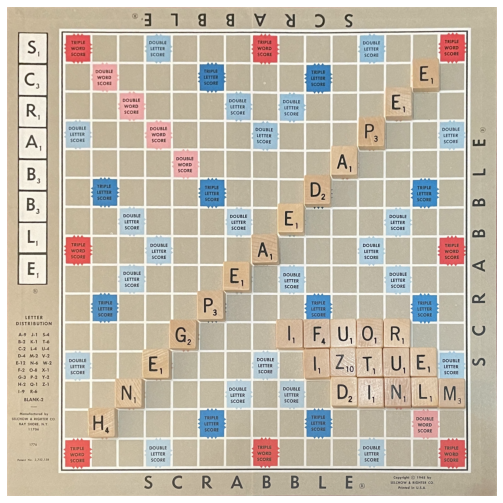

In [22]:
im_test_transformed = cv2.warpPerspective(im_test, M, dsize=(canonical_len_px, canonical_len_px))

fig = plt.figure(figsize=(9, 9))
plt.imshow(im_test_transformed)
plt.axis('off')

In [23]:
cv2.imwrite('foo.png', cv2.cvtColor(im_test_transformed, cv2.COLOR_RGB2BGR))

True

(-0.5, 1874.5, 1874.5, -0.5)

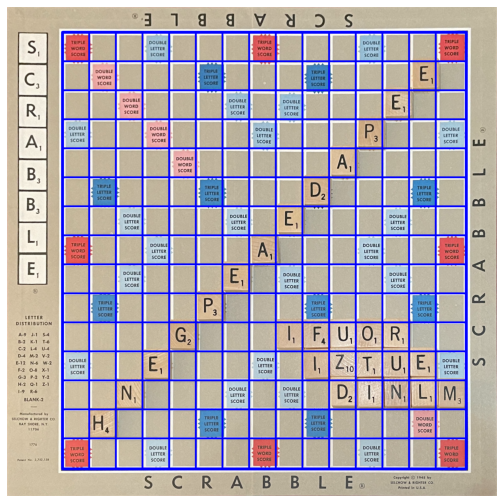

In [24]:
im = im_test_transformed.copy()
im = cv2.polylines(im, [p_Cgrid_C], isClosed=True, color=(0, 0, 255), thickness=10)

for i in range(14):
    dx = int(xmin + (i + 1) * tile_xlen_px)
    im = cv2.line(im, (dx, int(ymin)), (dx, int(ymax)), (0, 0, 255), 5)
    dy = int(ymin + (i + 1) * tile_ylen_px)
    
    im = cv2.line(im, (int(xmin), dy), (int(xmax), dy), (0, 0, 255), 5)
    
fig = plt.figure(figsize=(9, 9))
plt.imshow(im)
plt.axis('off')

In [25]:
cv2.imwrite('foo_grid.png', cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

True